In [ ]:
import matplotlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import GridWorld_env
from replay_buffer import PrioritizedReplayBuffer
import gymnasium as gym
import random
import math
from itertools import count

device = "cuda" if torch.cuda.is_available() else "cpu"
is_ipython = "inline" in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [ ]:
from collections import deque, namedtuple

Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))

class ReplayBuffer(object):
    def __init__(self, capacity) -> None:
        self.memory = deque([], maxlen=capacity)
    
    def push(self, *args):
        self.memory.append(Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
    

In [ ]:
class DQN(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(DQN, self).__init__()
               
        self.conv1 = nn.Conv3d(3, 13, 3, 1, 1)
        
        self.conv2 = nn.Conv3d(32, 32, 3, 1, 1)
        
        self.fc1 = nn.Linear((64 + 3*2)*input_dim * input_dim * input_dim, 512)
        
        self.actions = nn.Linear(1024, action_dim)
        self.advantage = nn.Linear(1024, 1)
    def forward(self, x):
        original_state = x
               
        x = self.conv1(x)

        x = torch.cat([x, original_state], dim=1)
        x = torch.cat([x, -x], dim = 1)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = torch.cat([x, original_state], dim=1)
        x = torch.cat([x, -x], dim = 1)

        x = F.relu(x)
        x = nn.Flatten()(x)
        x = self.fc1(x)
        x = torch.cat([x, -x], dim = -1)
        x = F.relu(x)
        actions = self.actions(x)
        advantage = self.advantage(x)
        x = advantage + (actions - actions.mean(dim=1, keepdim=True))
        return x
"""
test = DQN(4, 7)
import torchinfo
print(torchinfo.summary(test, (1, 3, 4, 4, 4)))"""


In [ ]:
BATCH_SIZE = 32
GAMMA = 0.8
EPS_START = 0.99
EPS_END = 0.01
EPS_DECAY = 65000
TAU = 0.0005
STEPSIZE = 0.0000625
BETA_START = 0.4
BETA_END = 1
BETA_LINEAR_CAP = 250 * 750
N_STEP = 3

n_actions = 7
env = gym.make("GridWorld_env/GridWorld", dimension_size=4, path="targets")
env.reset()

policy_net = DQN(4, 7)
target_net = DQN(4, 7)

policy_net.cuda()
target_net.cuda()
target_net.load_state_dict(policy_net.state_dict())

optimiser = optim.Adam(policy_net.parameters(), lr=STEPSIZE, eps=1.5e-4)
# memory = ReplayBuffer(256)
memory = PrioritizedReplayBuffer(obs_dim=(3,4,4,4), size=1024, n_step=N_STEP, gamma = GAMMA)

steps_done = 0

In [ ]:
def select_action(state, greedy = False):
    global steps_done
    
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    
    if greedy:
        return policy_net(state).max(1).indices.view(1,1)
        
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1,1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
    

In [ ]:
def boltzmann_action(state, num_actions):

    global steps_done
    steps_done +=1
    C = 5
    with torch.no_grad():
        
        Beta = C / (torch.sqrt(num_actions) + 0.05)
        mean_reward = policy_net(state)
        action_estimate =  mean_reward + Beta*torch.distributions.gumbel.Gumbel(torch.zeros(1,n_actions), torch.ones(1, n_actions)).sample().to(device)

    #print(action_estimate)
    action = torch.argmax(action_estimate).view(1,1)
    #print(action.device)
    return action


In [ ]:
episode_durations = []

def plot_durations(show_result = False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title("Result")
    else:
        plt.clf()
        plt.title("Training")
    plt.xlabel("Episode")
    plt.ylabel("Duration")
    
    plt.plot(durations_t.numpy())
    
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
        
        plt.pause(0.001)
        if is_ipython:
            if not show_result:
                display.display(plt.gcf())
                display.clear_output(wait=True)
            else:
                display.display(plt.gcf())
                

In [ ]:
def optimise_model(beta):
    if len(memory) < BATCH_SIZE * 16:
        return 0, 0
    # transitions = memory.sample(BATCH_SIZE)
    transitions = memory.sample_batch(beta)
    # batch = Transition(*zip(*transitions))
    # batch = []
    batch = Transition(
        torch.tensor(transitions["obs"], device=device),
        torch.tensor(transitions["acts"], device=device, dtype=torch.int64),
        torch.tensor(transitions["next_obs"], device=device),
        torch.tensor(transitions["rews"], device=device)
    )
    
    indices = transitions["indices"]
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s.unsqueeze(0) for s in batch.next_state if s is not None])
    
    state_batch = batch.state
    action_batch = batch.action
    reward_batch = batch.reward
    
    tmp = policy_net(state_batch)
    state_action_values = tmp.gather(1, action_batch.unsqueeze(1))
    next_state_values = torch.zeros(BATCH_SIZE, device = device)
    
    #double dqn
    max_a = policy_net(non_final_next_states).detach().max(1).indices
    next_state_values[non_final_mask] = target_net(non_final_next_states).detach().gather(1, max_a.unsqueeze(1)).squeeze(1)
    #next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    with torch.no_grad():
        expected_state_action_values = (GAMMA ** N_STEP) * next_state_values + reward_batch
    criterion = nn.MSELoss()
    
    weights = torch.tensor(transitions["weights"], device=device)
    weights = weights ** 0.5
    
    loss = criterion(weights * state_action_values , weights * expected_state_action_values.unsqueeze(1))
    
    optimiser.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimiser.step()
    
    new_priorities = torch.abs(state_action_values - expected_state_action_values.unsqueeze(1)).detach().cpu().numpy() + 1e-7 #loss.detach().cpu().numpy() + 1e-6
    #print(len(indices), new_priorities.shape, new_priorities)
    memory.update_priorities(indices, new_priorities)
    return loss.item(), reward_batch.float()
        

In [ ]:
reward_plot = []

In [ ]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 1

num_actions = torch.zeros(n_actions, device=device)

try:
    for i_episode in tqdm(range(num_episodes)):
        # Initialize the environment and get its state
        state, info = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        cummulative_reward = 0
        for t in count():
            action = select_action(state)
    
            num_actions[action] +=1
    
            observation, reward, terminated, truncated, _ = env.step(action.item())
    
            cummulative_reward += reward
            reward = torch.tensor([reward], device=device)
    
            done = terminated or truncated
            if terminated:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
    
            # Store the transition in memory
            # memory.push(state, action, next_state, reward)
            memory.store(state.cpu().numpy(), action, reward, next_state.cpu().numpy(), done)
            # Move to the next state
            state = next_state
    
            # Perform one step of the optimization (on the policy network)
            beta = BETA_START + (BETA_END - BETA_START) * (steps_done) / BETA_LINEAR_CAP if steps_done < BETA_LINEAR_CAP else BETA_END
            l, r = optimise_model(beta)
    
            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)
            
            if done:
                episode_durations.append(t + 1)
                plot_durations()
                break
        #if i_episode % 25 == 0:
            #target_net.load_state_dict(policy_net.state_dict())
            
        if i_episode % 10 == 0 and i_episode > 1:
            print("Episode: {0} Loss {1} Mean Sample Reward {2}:" .format(i_episode, l, r.mean().item()))
            #print(env.unwrapped.get_seqsuence())
            env.unwrapped.render()
    
        reward_plot.append(cummulative_reward)
except KeyboardInterrupt:
    pass

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()


In [ ]:
plt.plot(reward_plot)
plt.show()

In [ ]:
torch.save(policy_net, "policy_double_dueling_dqn_crelu_Pbuffer.pt")
torch.save(target_net, "target_double_dueling_dqn_crelu_Pbuffer.pt")

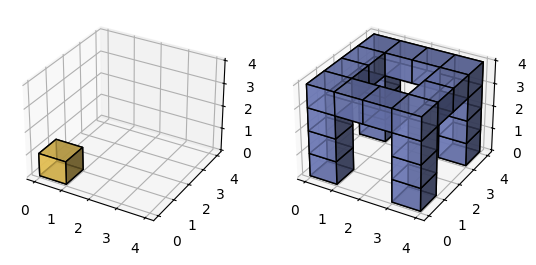

In [ ]:
from time import sleep
state, info = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
for t in count():
    action = select_action(state, greedy = True)
    observation, reward, terminated, truncated, _ = env.step(action.item())
    reward = torch.tensor([reward], device=device)
    done = terminated or truncated

    if terminated:
        next_state = None
    else:
        next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

    # Store the transition in memory
    #memory.push(state, action, next_state, reward)

    # Move to the next state
    state = next_state
    if terminated or truncated:
        print(t)
        break

    sleep(0.3)
    display.clear_output(True)
    env.unwrapped.render()

    # Perform one step of the optimization (on the policy network)


In [ ]:
env.reset()
state = env.get_obs()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

target_net(state)

In [ ]:
env.step(3)
env.render()
state = env.get_obs()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

policy_net(state)

In [ ]:
torch.save(policy_net, "policy.pt")

In [ ]:
torch.save(target_net, "target.pt")